# Design 4-color smFISH

by Pu Zheng


In [1]:
# Basic imports
import os,sys,re
from importlib import reload
import numpy as np
import pandas as pd
#import torch
print(os.getpid())

469804


In [2]:
# ChromAn related imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/ChromAn') # parent folder of ChromAn
import src

## Master folder
folder storing all the libraries

In [3]:
library_master_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes'
print(f"- FISH probe libraries stored in folder: {library_master_folder}")

- FISH probe libraries stored in folder: /lab/solexa_weissman/puzheng/MERFISH_Probes


## References:

GRCm39:
https://ftp.ensembl.org/pub/release-109/fasta/mus_musculus/ 

In [4]:
reference_folder = r'/lab/solexa_weissman/puzheng/References/'
print(os.listdir(os.path.join(reference_folder, 'GRCm39', 'Transcriptome')))

['Mus_musculus.GRCm39.ncrna.fa', 'rtRNA_15.table', '.DS_Store', 'Mus_musculus.GRCm39.cdna.all.fa', 'transcriptome_17.table', 'Mus_musculus.GRCm39.109.gff3']


# Define design parameters

## Folders

In [5]:
# Define the output files
library_folder = os.path.join(library_master_folder, 'smFISH', 'Cldn4_Fscn1')
print(f"- library will be saved in: {library_folder}")
if not os.path.exists(library_folder):
    os.makedirs(library_folder)
    print(f"-- create library_folder: {library_folder}")
probe_output_file = os.path.join(library_folder, 'designed_probes.csv')
print(f"-- library savefile: {probe_output_file}")
probe_output_idt_file = os.path.join(library_folder, 'designed_probes_idt_oPool.xlsx')
print(f"-- library IDT format savefile: {probe_output_idt_file}")

- library will be saved in: /lab/solexa_weissman/puzheng/MERFISH_Probes/smFISH/Cldn4_Fscn1
-- library savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/smFISH/Cldn4_Fscn1/designed_probes.csv
-- library IDT format savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/smFISH/Cldn4_Fscn1/designed_probes_idt_oPool.xlsx


In [6]:
# Define transcriptome reference
mRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome', 
                                      r'Mus_musculus.GRCm39.cdna.all.fa')
ncRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.ncrna.fa')
gff3_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.109.gff3')

# Define readout sequences
readout_fasta_file = os.path.join(reference_folder, 'Readouts',
                                  r'updated_Stvs.fasta')
if os.path.isfile(readout_fasta_file):
    print("readout_fasta_file exists")
else:
    print("readout_fasta_file doesn't exist")
    
# Define primer sequences
forward_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'forward_primers_keep.fasta')
reverse_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'reverse_primers_keep.fasta')
                                   #r'T7_reverse_primers.fasta')
selected_primers_file = os.path.join(library_folder, 'selected_primers.csv')

print(os.path.isfile(forward_primer_file), os.path.isfile(reverse_primer_file))
# Define FPKM reference (Not necessary for smFISH)
fpkm_tracking_file = os.path.join(library_folder, r'isoforms.fpkm_tracking')

readout_fasta_file exists
True True


## Packages

for MERFISH probe design, please refer to package: 
https://github.com/zhengpuas47/MERFISH_probe_design

In [7]:
import numpy as np
import pandas as pd

from IPython.display import display

import MERFISH_probe_design.IO.file_io as fio
import MERFISH_probe_design.probe_design.probe_dict as p_d
import MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.probe_design.readout_sequences as rs
import MERFISH_probe_design.probe_design.probe_selection as ps
import MERFISH_probe_design.probe_design.quality_check as qc
from MERFISH_probe_design.probe_design import filters
from MERFISH_probe_design.probe_design import plot
from MERFISH_probe_design.probe_design import primer_design

# Design targeting sequences

## Load required parameters

In [8]:
%%time
# Load the transcriptome as a pandas data frame
cdna = fio.load_transcriptome(mRNA_fasta_file, None)
# Make sure that the transcriptome data frame has the standard column names.
# The standard columns are: transcript_id, sequence, gene_id, gene_short_name and FPKM.
# Also remove the non-standard columns for clarity.
cdna = qc.check_and_standardize_transcriptome(cdna, remove_non_standard_columns=True)

ncRNAs =  fio.load_fasta_into_df(ncRNA_fasta_file, None)
transcriptome = pd.concat([cdna, ], ignore_index=True)
#transcriptome = fio.load_transcriptome(mRNA_fasta_file, fpkm_tracking_file) #MERFISH version

# This FPKM data is not for our cell type of interest. So set the FPKMs to be all 1.
transcriptome['FPKM'] = 1

Loaded 116912 transcripts.
116912
CPU times: user 2.21 s, sys: 314 ms, total: 2.53 s
Wall time: 2.53 s


In [9]:
transcriptome

,transcript_id,sequence,FPKM,gene_id,gene_short_name
0,ENSMUST00000178537.2,GGGACAGGGGGC,1,ENSMUSG00000095668.2,Trbd1
1,ENSMUST00000178862.2,GGGACTGGGGGGGC,1,ENSMUSG00000094569.2,Trbd2
2,ENSMUST00000196221.2,ATGGCATAT,1,ENSMUSG00000096749.3,Trdd1
3,ENSMUST00000179664.2,ATGGCATATCA,1,ENSMUSG00000096749.3,Trdd1
4,ENSMUST00000177564.2,ATCGGAGGGATACGAG,1,ENSMUSG00000096176.2,Trdd2
...,...,...,...,...,...
116907,ENSMUST00000215557.2,ATGTAAAACCAGAGCTTTGTCACTGAGTTTCTACTGTGAGGCTTAT...,1,ENSMUSG00000111578.2,Gm18166
116908,ENSMUST00000215627.2,ATGTAAAACCAGAGCTTTGTCACTGAGTTTCTACTGTGAGGCTTAT...,1,ENSMUSG00000111460.2,None
116909,ENSMUST00000118137.2,ATGGATGAAGGCAATCACACTGTGGTGTCATAATTTACACTCTGGA...,1,ENSMUSG00000094074.2,None
116910,ENSMUST00000208680.2,AATAGGTCATCTAAGGCTCTGTCTACACTGACTGCTCATATCACAG...,1,ENSMUSG00000109287.2,Gm44713


In [10]:
# Let's have a look at the transcripts of the FLNA gene
transcriptome[transcriptome['gene_short_name'] == 'Cldn4'].sort_values('FPKM', ascending=False)

,transcript_id,sequence,FPKM,gene_id,gene_short_name
88244,ENSMUST00000051401.4,CTTTCTTGTTGCAGGTGCAGGCAGGAAAGAGCTGCAGTGTTCGCGC...,1,ENSMUSG00000047501.4,Cldn4


In [11]:
transcriptome[transcriptome['gene_short_name'] == 'Fscn1'].sort_values('FPKM', ascending=False)

,transcript_id,sequence,FPKM,gene_id,gene_short_name
91828,ENSMUST00000031565.15,CCGGGCTGGCTTTGTGGAGAACTGCAGCGGGCTAAGCCGTGTTGAA...,1,ENSMUSG00000029581.15,Fscn1
91829,ENSMUST00000198017.5,AAGCCGTGTTGAACAAAGGAGGTCGGGCACAGCTATCCAAGCTCCC...,1,ENSMUSG00000029581.15,Fscn1
91830,ENSMUST00000129306.4,GGAGCGTGCACATCGCCATGCACCCGCAGGTGGTGCTGCAGGCGGC...,1,ENSMUSG00000029581.15,Fscn1
91831,ENSMUST00000150622.8,TGCGGTAAACGTCTCTTGGGAATGTGACTGGAATGGACCTGTCAGC...,1,ENSMUSG00000029581.15,Fscn1
91832,ENSMUST00000137552.8,CTCTCTGCTTACAGAGCTGTGGCCGAGGCTTGTGCCCTGGGGAAGG...,1,ENSMUSG00000029581.15,Fscn1
91833,ENSMUST00000139131.3,GAGAGGCGATTCTTTTTGGCAAGGGAGGGAAACTGAGGCAGAGAGC...,1,ENSMUSG00000029581.15,Fscn1
91834,ENSMUST00000135293.2,CATCACCTGGCCTGGCTCTTCCCCCAGGACTGGGCAGCCTGCTCGA...,1,ENSMUSG00000029581.15,Fscn1


## Add mCherry into transcriptome

In [12]:
# sequence directly copied from the vector
gene1_row = pd.Series(
    {'transcript_id':'artificialTranscript_mCherry_t1',
     'sequence': 'ATGGTGAGCAAGGGCGAGGAGGATAACATGGCCATCATCAAGGAGTTCATGCGCTTCAAGGTGCACATGGAGGGCTCCGTGAACGGCCACGAGTTCGAGATCGAGGGCGAGGGCGAGGGCCGCCCCTACGAGGGCACCCAGACCGCCAAGCTGAAGGTGACCAAGGGCGGCCCCCTGCCCTTCGCCTGGGACATCCTGTCCCCTCAGTTCATGTACGGCTCCAAGGCCTACGTGAAGCACCCCGCCGACATCCCCGACTACTTGAAGCTGTCCTTCCCCGAGGGCTTCAAGTGGGAGCGCGTGATGAACTTCGAGGACGGCGGCGTGGTGACCGTGACCCAGGACTCCTCCCTGCAGGACGGCGAGTTCATCTACAAGGTGAAGCTGCGCGGCACCAACTTCCCCTCCGACGGCCCCGTAATGCAGAAGAAGACCATGGGCTGGGAGGCCTCCTCCGAGCGGATGTACCCCGAGGACGGCGCCCTGAAGGGCGAGATCAAGCAGAGGCTGAAGCTGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACAAGGCCAAGAAGCCCGTGCAGCTGCCCGGCGCCTACAACGTCAACATCAAGTTGGACATCACCTCCCACAACGAGGACTACACCATCGTGGAACAGTACGAACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTAATGAA',
     'FPKM': 1,
     'gene_id':'artificialTranscript_mCherry',
     'gene_short_name': 'mCherry',
    }
)

In [13]:
gene2_row = pd.Series(
    {'transcript_id':'artificialTranscript_UCOE_t1',
     'sequence': 'AAGGATCTGCGATATCGATAAGCTTGATATCGAATTCGGGAGGTGGTCCCTGCAGTTACGCCAATGATAACCCCCGCCAGAAAAATCTTAGTAGCCTTCCCTTTTTGTTTTCCGTGCCCCAACTCGGCGGATTGACTCGGCCCCTTCCGGAAACACCCGAATCAACTTCTAGTCAAATTATTGTTCACGCCGCAATGACCCACCCCTGGCCCGCGTCTGTGGAACTGACCCCTGGTGTACAGGAGAGTTCGCTGCTGAAAGTGGTCCCAAAGGGGTACTAGTTTTTAAGCTCCCAACTCCCCCTCCCCCAGCGTCTGGAGGATTCCACACCCTCGCACCGCAGGGGCGAGGAAGTGGGCGGAGTCCGGTTTTGGCGCCAGCCGCTGAGGCTGCCAAGCAGAAAAGCCACCGCTGAGGAGACTCCGGTCACTGTCCTCGCCCCGCCTCCCCCTTCCCTCCCCTTGGGGACCACCGGGCGCCACGCCGCGAACGGTAAGTGCCGCGGTCGTCGGCGCCTCCGCCCTCCCCCTAGGGCCCCAATTCCCAGCGGGCGCGGCGCGCGGCCCCTCCCCCCGCCGGGCGCGCGCCCGCTGCCCCGCCCTTCGTGGCCGCCCGGCGTGGGCGGTGCCACCCCTCCCCCCGGCGGCCCCCCTGCAGCCGCGCGCAGCTCCCGGCTCCCTCCCCCTTCGGATGTGGCTTGAGCTGTAGGCGCGGAGGGGCTCCG',
     'FPKM': 1,
     'gene_id':'artificialTranscript_UCOE',
     'gene_short_name': 'UCOE',
    }
)

In [14]:
transcriptome = pd.concat([transcriptome, gene1_row.to_frame().T, gene2_row.to_frame().T], ignore_index=True)
transcriptome

,transcript_id,sequence,FPKM,gene_id,gene_short_name
0,ENSMUST00000178537.2,GGGACAGGGGGC,1,ENSMUSG00000095668.2,Trbd1
1,ENSMUST00000178862.2,GGGACTGGGGGGGC,1,ENSMUSG00000094569.2,Trbd2
2,ENSMUST00000196221.2,ATGGCATAT,1,ENSMUSG00000096749.3,Trdd1
3,ENSMUST00000179664.2,ATGGCATATCA,1,ENSMUSG00000096749.3,Trdd1
4,ENSMUST00000177564.2,ATCGGAGGGATACGAG,1,ENSMUSG00000096176.2,Trdd2
...,...,...,...,...,...
116909,ENSMUST00000118137.2,ATGGATGAAGGCAATCACACTGTGGTGTCATAATTTACACTCTGGA...,1,ENSMUSG00000094074.2,None
116910,ENSMUST00000208680.2,AATAGGTCATCTAAGGCTCTGTCTACACTGACTGCTCATATCACAG...,1,ENSMUSG00000109287.2,Gm44713
116911,ENSMUST00000208550.2,ATGGATAAAAGAGAATCACTCTATTGTGTCTGAGTTTGTGTTCTTG...,1,ENSMUSG00000109522.2,None
116912,artificialTranscript_mCherry_t1,ATGGTGAGCAAGGGCGAGGAGGATAACATGGCCATCATCAAGGAGT...,1,artificialTranscript_mCherry,mCherry


## Select genes

In [15]:
## Specify genes here
sel_genes = ['Cldn4', 'Fscn1']
print(len(sel_genes))

2


### based on genes, select 2-color readouts

In [16]:
readout_df = fio.load_fasta_into_df(readout_fasta_file)
# select last 20 as readout sequences:
readout_df['sequence'] = [_s[-20:] for _s in readout_df['sequence']]

readout_names = list(readout_df['id'])
## Key parameters for readout usage
start_bit = 0
num_bit_per_gene = 4
bit_names = readout_names[start_bit:start_bit+num_bit_per_gene*len(sel_genes)]
readout_seqs = readout_df['sequence'][start_bit:start_bit+num_bit_per_gene*len(sel_genes)]

print(bit_names)

['Stv_3', 'Stv_4', 'Stv_5', 'Stv_6', 'Stv_7', 'Stv_8', 'Stv_9', 'Stv_10']


In [17]:
readout_df

,id,description,sequence
0,Stv_3,Stv_3 old_barcode,CCAGATCGGACGATCATGGG
1,Stv_4,Stv_4 old_barcode,GCGCGATTGACCGTCTCGTT
2,Stv_5,Stv_5 old_barcode,CCGATGCGCAGCAATTCACT
3,Stv_6,Stv_6 old_barcode,GCCACGGTCCCGTTGAACTT
4,Stv_7,Stv_7 old_barcode,CGTCCAGCGCGTCAAACAGA
...,...,...,...
70,Stv_131,Stv_131 old_barcode,CAGCGCGAACCCTGAGCAAA
71,Stv_133,Stv_133 old_barcode,CTCACGCTGGAAGTGATACG
72,Stv_136,Stv_136 old_barcode,ACCGAACCGACGTCGCAAAT
73,Stv_145,Stv_145 old_barcode,AAGTCGGTTGGGAGCGTCCC


### design 2-color barcode table

In [18]:
barcodes = []
for _i, _name in enumerate(sel_genes):
    _base_str = np.zeros(num_bit_per_gene*len(sel_genes), dtype=np.int32)
    _base_str[num_bit_per_gene*_i:num_bit_per_gene*_i+num_bit_per_gene] = 1
    barcodes.append(''.join(_base_str.astype(str)))

### combine

In [19]:
barcode_table = pd.DataFrame({'name':sel_genes, 
                              #'id':['ENSMUSG00000061527.8', 'ENSMUSG00000000731.16'], 
                              #'id':['ENSMUST00000023709.7', 'ENSMUST00000145975.8'], 
                              'barcode_str':barcodes})
barcode_table

,name,barcode_str
0,Cldn4,11110000
1,Fscn1,00001111


## Initialize probe dict

In [20]:
# Initialize the probe dictionary which is the carrier of the probes throught the design process.
probe_dict = p_d.init_probe_dict(sel_genes, transcriptome, 
                                 'gene_short_name', K=30)
p_d.print_probe_dict(probe_dict)

Found 8 transcripts for 2 target genes.
Gene	Transcript	N_probes
Cldn4
	ENSMUST00000051401.4	1787
Fscn1
	ENSMUST00000031565.15	2646
	ENSMUST00000198017.5	2128
	ENSMUST00000129306.4	768
	ENSMUST00000150622.8	315
	ENSMUST00000137552.8	537
	ENSMUST00000139131.3	571
	ENSMUST00000135293.2	437


## Calculate and filter by probe GC

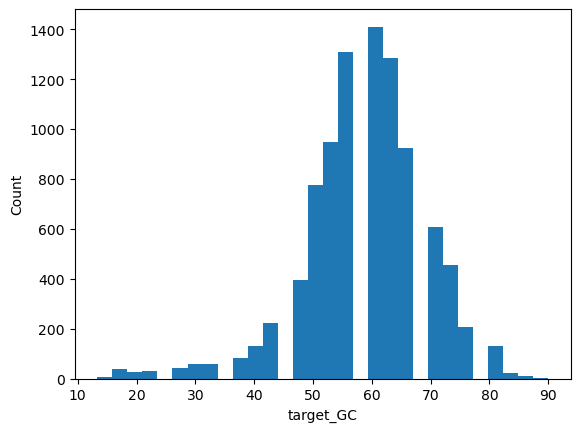

In [21]:
# Calculate and plot the GC contents of the target regions
filters.calc_gc_for_probe_dict(probe_dict, column_key_seq='target_sequence', column_key_write='target_GC')
plot.plot_hist(probe_dict, column_key='target_GC')

Cldn4
	ENSMUST00000051401.4: 1473 / 1787 probes passed the filter 40 < target_GC <  70.
Fscn1
	ENSMUST00000031565.15: 1819 / 2646 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000198017.5: 1590 / 2128 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000129306.4: 657 / 768 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000150622.8: 301 / 315 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000137552.8: 510 / 537 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000139131.3: 539 / 571 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000135293.2: 378 / 437 probes passed the filter 40 < target_GC <  70.


/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


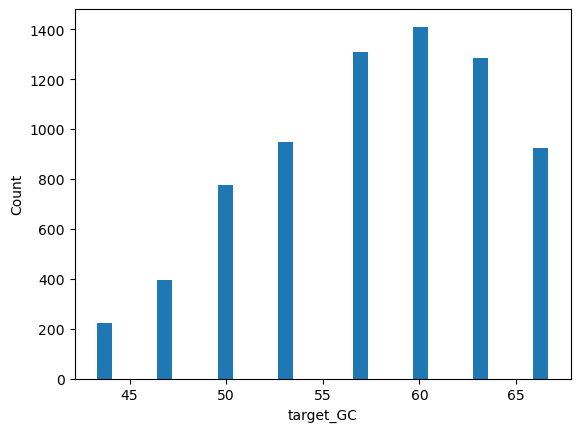

In [22]:
# Filter GC cotent and plot the GC content after filtering
filters.filter_probe_dict_by_metric(probe_dict, 'target_GC', lower_bound=40, upper_bound=70)
plot.plot_hist(probe_dict, column_key='target_GC', bins=30)

## Calculate and filter by probe Tm

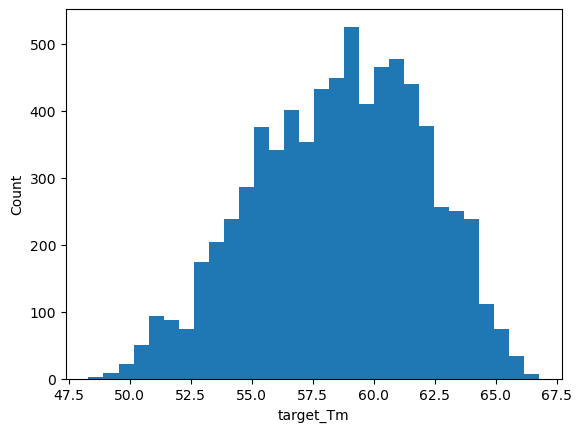

In [23]:
# Calculate and plot the melting-temperatures (Tm)
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=390, fmd_percentile=30, probe_conc=5,
                              column_key_seq='target_sequence', column_key_write='target_Tm')
plot.plot_hist(probe_dict, column_key='target_Tm')

Cldn4
	ENSMUST00000051401.4: 1457 / 1473 probes passed the filter 50 < target_Tm <  65.
Fscn1
	ENSMUST00000031565.15: 1777 / 1819 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000198017.5: 1548 / 1590 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000129306.4: 648 / 657 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000150622.8: 300 / 301 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000137552.8: 502 / 510 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000139131.3: 534 / 539 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000135293.2: 371 / 378 probes passed the filter 50 < target_Tm <  65.


/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


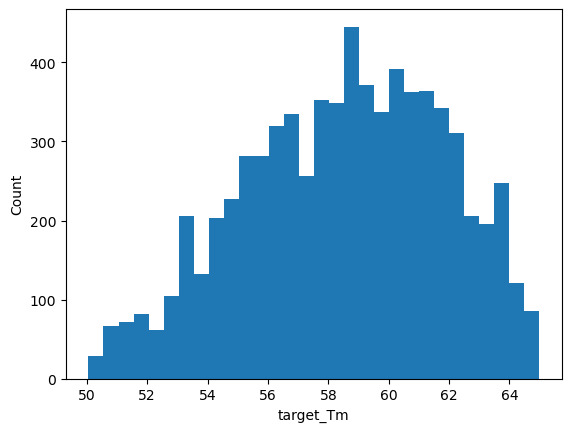

In [24]:
# Filter by Tm
# NOTE: here we used a higher upper bound for GC content and Tm than JM's original
# cutoffs. It was shown that higher Tm gives better signal-to-noise ratios in SM-FISH
filters.filter_probe_dict_by_metric(probe_dict, 'target_Tm', lower_bound=50, upper_bound=65)
plot.plot_hist(probe_dict, column_key='target_Tm')

## Calculate off-targets

### Generate CountTable

In [25]:
# Initialize the off-target counting tables
overwrite_ottable = True
# OTTable for rRNA/tRNAs
if 'ottable_rtRNAs' not in locals() or overwrite_ottable:
    
    ottable_rtRNAs = ot.get_OTTable_for_rtRNAs(ncRNAs, 15)

Found 378 rRNAs/tRNAs from 29245 non-coding RNAs.


In [26]:
# OTTables for the genes we target
if 'gene_ottable_dict' not in locals() or overwrite_ottable:
    #gene_ottable_dict = ot.get_gene_OTTables(transcriptome, sel_isoform_names, 'transcript_id', 17)
    gene_ottable_dict = ot.get_gene_OTTables(transcriptome, sel_genes, 'gene_short_name', 17)

Generate OTTable for gene Cldn4.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Fscn1.
Construct a OTTable using 7/7 transcripts with FPKM > 0.


In [27]:
# OTTable for the transcriptome.
if 'ottable_transcriptome' not in locals() or overwrite_ottable:
    ottable_transcriptome = ot.get_OTTable_for_transcriptome(transcriptome, 17)

Construct a OTTable using 116914/116914 transcripts with FPKM > 0.
Processed 10000/116914 sequences.
Processed 20000/116914 sequences.
Processed 30000/116914 sequences.
Processed 40000/116914 sequences.
Processed 50000/116914 sequences.
Processed 60000/116914 sequences.
Processed 70000/116914 sequences.
Processed 80000/116914 sequences.
Processed 90000/116914 sequences.
Processed 100000/116914 sequences.
Processed 110000/116914 sequences.


### Off-targets to rRNA/tRNAs

In [28]:
# Calculate and plot the off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_sequence', 'target_OT_rtRNA', 15)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA', y_max=400)
# Filter out probes that have any rRNA/tRNA off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_OT_rtRNA', upper_bound=0.5)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA')

Calculate OTs for 0/2 genes.
Calculate OTs for 1/2 genes.
Cldn4
	ENSMUST00000051401.4: 1457 / 1457 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Fscn1
	ENSMUST00000031565.15: 1777 / 1777 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000198017.5: 1548 / 1548 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000129306.4: 648 / 648 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000150622.8: 300 / 300 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000137552.8: 502 / 502 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000139131.3: 534 / 534 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000135293.2: 371 / 371 probes passed the filter -inf < target_OT_rtRNA <  0.5.


/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


### Off-targets to transcriptome

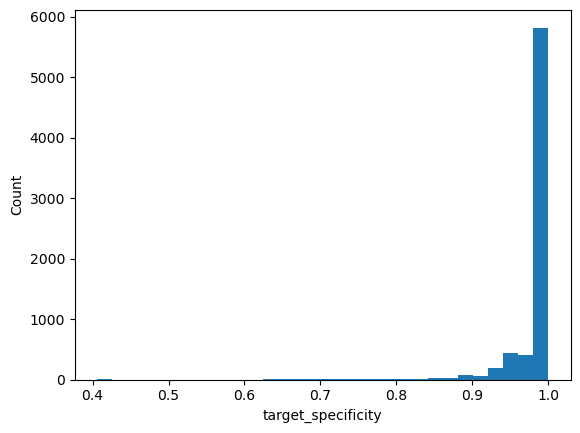

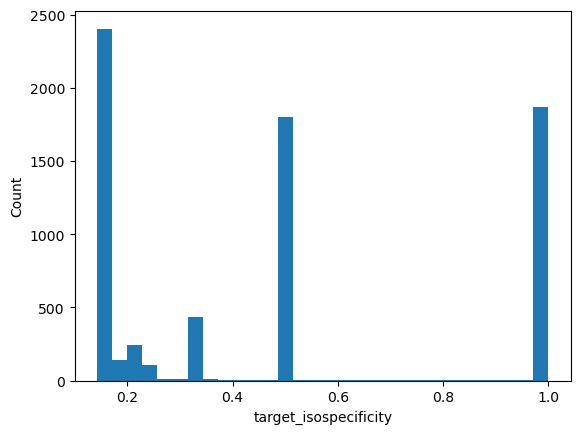

In [29]:
# Get the FPKMs of the transcripts
transcript_fpkms = dict(zip(list(transcriptome['transcript_id']), list(transcriptome['FPKM'])))

# Calculate the specificities and isoform specificities of the target regions
ot.calc_specificity(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms,
                    'target_sequence', 'target_specificity', 'target_isospecificity', 17)

plot.plot_hist(probe_dict, 'target_specificity')
plot.plot_hist(probe_dict, 'target_isospecificity')

In [30]:
# modify target isospecificity, if only one isoform exist:
for _gene, _transcript_2_df in probe_dict.items():
    if len(_transcript_2_df) == 1:
        for _transcript, _df in _transcript_2_df.items():
            probe_dict[_gene][_transcript]['target_isospecificity'] = 0.01

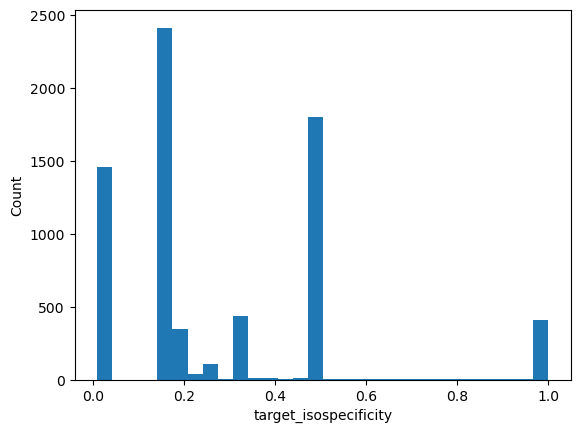

In [31]:
plot.plot_hist(probe_dict, 'target_isospecificity')

Cldn4
	ENSMUST00000051401.4: 1087 / 1457 probes passed the filter 0.99 < target_specificity <  inf.
Fscn1
	ENSMUST00000031565.15: 1402 / 1777 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000198017.5: 1219 / 1548 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000129306.4: 530 / 648 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000150622.8: 244 / 300 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000137552.8: 378 / 502 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000139131.3: 428 / 534 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000135293.2: 273 / 371 probes passed the filter 0.99 < target_specificity <  inf.


/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


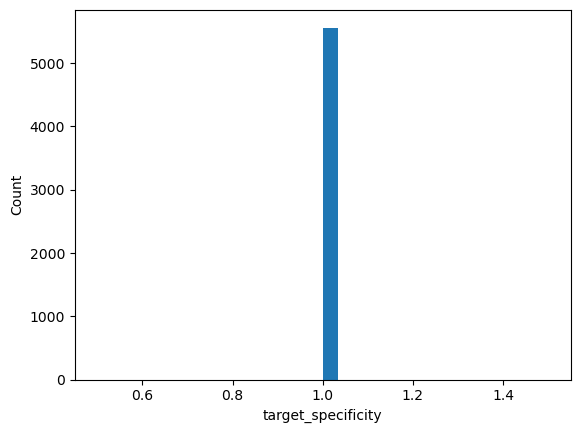

In [32]:
# Filter the specificities of the target regions
# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_specificity', lower_bound=0.99)
plot.plot_hist(probe_dict, 'target_specificity')

Cldn4
	ENSMUST00000051401.4: 1087 / 1087 probes passed the filter 0.0 < target_isospecificity <  0.66.
Fscn1
	ENSMUST00000031565.15: 1232 / 1402 probes passed the filter 0.0 < target_isospecificity <  0.66.
	ENSMUST00000198017.5: 1219 / 1219 probes passed the filter 0.0 < target_isospecificity <  0.66.
	ENSMUST00000129306.4: 524 / 530 probes passed the filter 0.0 < target_isospecificity <  0.66.
	ENSMUST00000150622.8: 223 / 244 probes passed the filter 0.0 < target_isospecificity <  0.66.
	ENSMUST00000137552.8: 359 / 378 probes passed the filter 0.0 < target_isospecificity <  0.66.
	ENSMUST00000139131.3: 321 / 428 probes passed the filter 0.0 < target_isospecificity <  0.66.
	ENSMUST00000135293.2: 262 / 273 probes passed the filter 0.0 < target_isospecificity <  0.66.


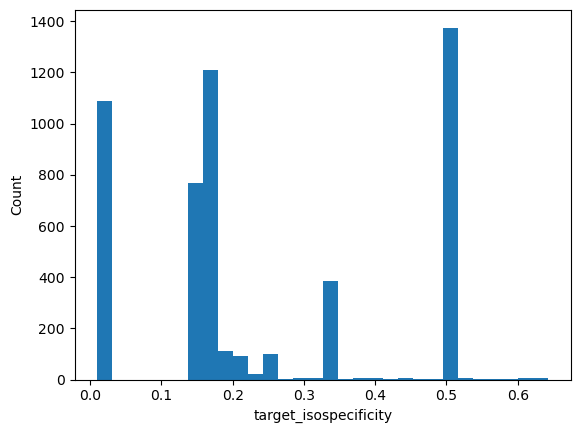

In [33]:
# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_isospecificity', 
                                    lower_bound=0., upper_bound=0.66)
plot.plot_hist(probe_dict, 'target_isospecificity')

## Select the transcript with the most probes

In [34]:
select_transcripts = True
if select_transcripts:
    # Manual selection
    #probe_dict = p_d.select_transcripts_by_ids(probe_dict, transcript_ids=['ENSMUST00000003100.10', ])
    
    # Select the transcript with most probes passed QC:
    probe_dict = p_d.select_transcripts_by_num_probes(probe_dict)
    p_d.print_probe_dict(probe_dict) # We excluded all the transcripts that are not our direct targets

Gene	Transcript	N_probes
Cldn4
	ENSMUST00000051401.4	1087
Fscn1
	ENSMUST00000031565.15	1232


In [35]:
# save this probe_dict for now:
import pickle
probe_dict_savefile = os.path.join(library_folder, 'candidate_probe_dict.pkl')
pickle.dump(probe_dict, open(probe_dict_savefile, 'wb'))

# Add readouts

In [36]:
# Load readouts
readout_seqs = readout_df[start_bit:start_bit+num_bit_per_gene*len(sel_genes)]
rs.append_on_bit_ids_to_readout_sequences(readout_seqs, bit_names)
readout_seqs

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/readout_sequences.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readout_seqs['on-bit'] = pd.Series(on_bits, index=readout_seqs.index)


,id,description,sequence,on-bit
0,Stv_3,Stv_3 old_barcode,CCAGATCGGACGATCATGGG,0
1,Stv_4,Stv_4 old_barcode,GCGCGATTGACCGTCTCGTT,1
2,Stv_5,Stv_5 old_barcode,CCGATGCGCAGCAATTCACT,2
3,Stv_6,Stv_6 old_barcode,GCCACGGTCCCGTTGAACTT,3
4,Stv_7,Stv_7 old_barcode,CGTCCAGCGCGTCAAACAGA,4
5,Stv_8,Stv_8 old_barcode,CCGTAACGAGCGTCCCTTGC,5
6,Stv_9,Stv_9 old_barcode,CCTGGCGTTGCGACGACTAA,6
7,Stv_10,Stv_10 old_barcode,CGGTCCACCGTTGCGCTTAC,7


In [37]:
reload(rs)

<module 'MERFISH_probe_design.probe_design.readout_sequences' from '/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/readout_sequences.py'>

In [38]:
# Add the readout sequences. Here we randomly add 2 readout sequences to each probe.
# Add an "T" between the concatenated sequences.
# Force each probe to have the same readout sequence
num_readout_per_probe = 3
rs.add_readout_seqs_to_probes_random(probe_dict, readout_seqs, barcode_table, 
                                     num_readout_per_probe, 
                                     spacer='a', gene_id_key='name', 
                                     each_probe_1_on_bit=False)

0
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 1 Stv_4 GCGCGATTGACCGTCTCGTT
1
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
2
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 1 Stv_4 GCGCGATTGACCGTCTCGTT
3
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
4
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 0 Stv_3 CCAGATCGGACGATCATGGG
5
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 1 Stv_4 GCGCGATTGACCGTCTCGTT
6
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 1 Stv_4 GCGCGATTGACCGTCTCGTT
7
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
8
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 1 Stv_4 GCGCGATTGACCGTCTCGTT
9
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 0 Stv_3 CCAGATCGGACGATCATGGG
10
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 1 Stv_4 GCGCGA

1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
136
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 0 Stv_3 CCAGATCGGACGATCATGGG
137
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
138
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 0 Stv_3 CCAGATCGGACGATCATGGG
139
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 0 Stv_3 CCAGATCGGACGATCATGGG
140
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
141
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
142
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 0 Stv_3 CCAGATCGGACGATCATGGG
143
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 0 Stv_3 CCAGATCGGACGATCATGGG
144
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 0 Stv_3 CCAGATCGGACGATCATGGG
145
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 0 Stv_3 CCAGATCGGACGATCATGGG

2 2 Stv_5 CCGATGCGCAGCAATTCACT
249
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 0 Stv_3 CCAGATCGGACGATCATGGG
250
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
251
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
252
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 0 Stv_3 CCAGATCGGACGATCATGGG
253
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 1 Stv_4 GCGCGATTGACCGTCTCGTT
254
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 1 Stv_4 GCGCGATTGACCGTCTCGTT
255
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
256
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 2 Stv_5 CCGATGCGCAGCAATTCACT
257
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
258
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 1 Stv_4 GCGCGATTGACCGTCTCGTT

0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 2 Stv_5 CCGATGCGCAGCAATTCACT
470
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
471
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 0 Stv_3 CCAGATCGGACGATCATGGG
472
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 2 Stv_5 CCGATGCGCAGCAATTCACT
473
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 0 Stv_3 CCAGATCGGACGATCATGGG
474
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 1 Stv_4 GCGCGATTGACCGTCTCGTT
475
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
476
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 2 Stv_5 CCGATGCGCAGCAATTCACT
477
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
478
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 2 Stv_5 CCGATGCGCAGCAATTCACT
479
0 1 Stv_4 GCGCGATTGACCGTCTCGTT

1 0 Stv_3 CCAGATCGGACGATCATGGG
2 2 Stv_5 CCGATGCGCAGCAATTCACT
568
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 0 Stv_3 CCAGATCGGACGATCATGGG
569
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
570
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 1 Stv_4 GCGCGATTGACCGTCTCGTT
571
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 0 Stv_3 CCAGATCGGACGATCATGGG
572
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 0 Stv_3 CCAGATCGGACGATCATGGG
588
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 0 Stv_3 CCAGATCGGACGATCATGGG
589
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 2 Stv_5 CCGATGCGCAGCAATTCACT
590
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
591
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
592
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT

2 3 Stv_6 GCCACGGTCCCGTTGAACTT
721
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
722
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
723
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 0 Stv_3 CCAGATCGGACGATCATGGG
724
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 2 Stv_5 CCGATGCGCAGCAATTCACT
725
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 0 Stv_3 CCAGATCGGACGATCATGGG
726
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 0 Stv_3 CCAGATCGGACGATCATGGG
727
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 0 Stv_3 CCAGATCGGACGATCATGGG
728
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 1 Stv_4 GCGCGATTGACCGTCTCGTT
729
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
730
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 3 Stv_6 GCCACGGTCCCGTTGAACTT

0 0 Stv_3 CCAGATCGGACGATCATGGG
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
859
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 1 Stv_4 GCGCGATTGACCGTCTCGTT
860
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
861
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 2 Stv_5 CCGATGCGCAGCAATTCACT
862
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
863
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
864
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
865
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 1 Stv_4 GCGCGATTGACCGTCTCGTT
866
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 1 Stv_4 GCGCGATTGACCGTCTCGTT
867
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
868
0 2 Stv_5 CCGATGCGCAGCAATTCACT

1 0 Stv_3 CCAGATCGGACGATCATGGG
2 2 Stv_5 CCGATGCGCAGCAATTCACT
957
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 0 Stv_3 CCAGATCGGACGATCATGGG
958
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 0 Stv_3 CCAGATCGGACGATCATGGG
959
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 0 Stv_3 CCAGATCGGACGATCATGGG
960
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 0 Stv_3 CCAGATCGGACGATCATGGG2
961
0  Stv_5 CCGATGCGCAGCAATTCACT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
962
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
963
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
964
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 0 Stv_3 CCAGATCGGACGATCATGGG
965
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
966
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT

1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
1070
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
1071
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
1072
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
1073
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 2 Stv_5 CCGATGCGCAGCAATTCACT
1074
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
1075
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 1 Stv_4 GCGCGATTGACCGTCTCGTT
1076
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
1077
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 0 Stv_3 CCAGATCGGACGATCATGGG
1078
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
1079
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 1 Stv_4 GCGCGATTGA

2 0 Stv_3 CCAGATCGGACGATCATGGG
1200
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
1201
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
1202
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
1203
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 0 Stv_3 CCAGATCGGACGATCATGGG
1204
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
1205
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
1206
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
1207
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 2 Stv_5 CCGATGCGCAGCAATTCACT
1208
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 2 Stv_5 CCGATGCGCAGCAATTCACT
1209
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 0 Stv_3 CCAGATCGGA

0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
1312
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 2 Stv_5 CCGATGCGCAGCAATTCACT
1313
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 1 Stv_4 GCGCGATTGACCGTCTCGTT
1314
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
1315
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 0 Stv_3 CCAGATCGGACGATCATGGG
1316
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 2 Stv_5 CCGATGCGCAGCAATTCACT
1317
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
1321
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 2 Stv_5 CCGATGCGCAGCAATTCACT
1322
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
1323
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 2 Stv_5 CCGATGCGCAGCAATTCACT
1324
0 3 Stv_6 GCCACGGTCC

1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 0 Stv_3 CCAGATCGGACGATCATGGG
1441
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 1 Stv_4 GCGCGATTGACCGTCTCGTT
1442
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
1443
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 0 Stv_3 CCAGATCGGACGATCATGGG
1444
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 1 Stv_4 GCGCGATTGACCGTCTCGTT
1445
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
1446
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 1 Stv_4 GCGCGATTGACCGTCTCGTT
1447
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
1448
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
1449
0 3 Stv_6 GCCACGGTCCCGTTGAACTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 2 Stv_5 CCGATGCGCAGCAATTCACT
1450
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 3 Stv_6 GCCACGGTCC

2 1 Stv_4 GCGCGATTGACCGTCTCGTT
1571
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 0 Stv_3 CCAGATCGGACGATCATGGG
1572
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 0 Stv_3 CCAGATCGGACGATCATGGG
1573
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 0 Stv_3 CCAGATCGGACGATCATGGG
1574
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 1 Stv_4 GCGCGATTGACCGTCTCGTT
2 0 Stv_3 CCAGATCGGACGATCATGGG
1575
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
1576
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 2 Stv_5 CCGATGCGCAGCAATTCACT
1577
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 2 Stv_5 CCGATGCGCAGCAATTCACT
1578
0 1 Stv_4 GCGCGATTGACCGTCTCGTT
1 2 Stv_5 CCGATGCGCAGCAATTCACT
2 3 Stv_6 GCCACGGTCCCGTTGAACTT
1579
0 2 Stv_5 CCGATGCGCAGCAATTCACT
1 0 Stv_3 CCAGATCGGACGATCATGGG
2 1 Stv_4 GCGCGATTGACCGTCTCGTT
1580
0 0 Stv_3 CCAGATCGGACGATCATGGG
1 3 Stv_6 GCCACGGTCCCGTTGAACTT
2 2 Stv_5 CCGATGCGCA

2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
34
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
35
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
36
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
37
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
38
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
39
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
40
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
41
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
42
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
43
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
44
0

2 6 Stv_9 CCTGGCGTTGCGACGACTAA
203
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
204
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
205
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
206
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
207
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
208
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
209
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
211
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
212
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
217
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 7 Stv_10 CGGTCCACCGT

1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
897
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
898
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
899
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
900
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
901
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
902
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
906
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
907
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
908
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
909
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 6 Stv_9 CCTGGCGTTGCGA

0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1001
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1002
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1003
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1004
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1005
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1006
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1007
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1008
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1009
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1010
0 6 Stv_9 CC

2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1097
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1098
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1099
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1100
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1101
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1102
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1103
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1104
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1105
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1106
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 5 Stv_8 CCGT

1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1180
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1181
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1182
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1227
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1228
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1229
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1230
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1231
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1232
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1233
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 4 Stv_7 CG

0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1313
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1314
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1315
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1316
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1317
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1318
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1319
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1320
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1321
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1322
0 5 Stv_8 C

2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1444
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1445
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1446
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1447
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1464
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1465
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1466
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1467
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1468
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1469
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 7 Stv_10 CGGT

1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1615
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1616
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1617
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1618
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1619
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1620
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1621
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1622
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1623
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1624
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 5 Stv_8 CCG

0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1735
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1736
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1737
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1738
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1739
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1740
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1741
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1742
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 5 Stv_8 CCGTAACGAGCGTCCCTTGCStv_7
2 4  CGTCCAGCGCGTCAAACAGA
1743
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1744
0 6 Stv_9 CC

0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1857
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1858
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1859
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1860
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1861
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1862
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
1863
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1864
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1879
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1880
0 4 Stv_7 CGTC

2040
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2041
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
2042
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
2043
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
2044
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2045
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2046
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
2047
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2062
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2063
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2064
0 4 Stv_

2137
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2138
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2139
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2140
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
2141
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2142
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2143
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2144
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2145
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2146
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2147
0 5 Stv_8

2 6 Stv_9 CCTGGCGTTGCGACGACTAA
2304
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2305
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2306
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
2307
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2308
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2309
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
2310
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
2311
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2312
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2313
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 7 Stv_10 CG

2 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2497
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2498
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2499
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 7 Stv_10 CGGTCCACCGTTGCGCTTAC
2 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2500
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2501
0 7 Stv_10 CGGTCCACCGTTGCGCTTAC
1 6 Stv_9 CCTGGCGTTGCGACGACTAA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2502
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2503
0 4 Stv_7 CGTCCAGCGCGTCAAACAGA
1 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
2504
0 6 Stv_9 CCTGGCGTTGCGACGACTAA
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 5 Stv_8 CCGTAACGAGCGTCCCTTGC
2505
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 6 Stv_9 CCTGGCGTTGCGACGACTAA
2506
0 5 Stv_8 CCGTAACGAGCGTCCCTTGC
1 4 Stv_7 CGTCCAGCGCGTCAAACAGA
2 7 Stv_10 CGGT

In [39]:
probe_dict['Fscn1']['ENSMUST00000031565.15']

,gene_id,transcript_id,shift,target_sequence,target_GC,target_Tm,target_OT_rtRNA,target_specificity,target_isospecificity,readout_names,probe_barcode,target_readout_sequence
29,Fscn1,ENSMUST00000031565.15,29,GGCTAAGCCGTGTTGAACAAAGGAGGTCGG,56.666667,57.648623,0,1.0,0.642857,Stv_7::Stv_8:Stv_9,00001110,CGTCCAGCGCGTCAAACAGAaGGCTAAGCCGTGTTGAACAAAGGAG...
30,Fscn1,ENSMUST00000031565.15,30,GCTAAGCCGTGTTGAACAAAGGAGGTCGGG,56.666667,57.648623,0,1.0,0.607143,Stv_8::Stv_7:Stv_9,00001110,CCGTAACGAGCGTCCCTTGCaGCTAAGCCGTGTTGAACAAAGGAGG...
31,Fscn1,ENSMUST00000031565.15,31,CTAAGCCGTGTTGAACAAAGGAGGTCGGGC,56.666667,57.648623,0,1.0,0.571429,Stv_8::Stv_7:Stv_10,00001101,CCGTAACGAGCGTCCCTTGCaCTAAGCCGTGTTGAACAAAGGAGGT...
32,Fscn1,ENSMUST00000031565.15,32,TAAGCCGTGTTGAACAAAGGAGGTCGGGCA,53.333333,58.446535,0,1.0,0.535714,Stv_8::Stv_9:Stv_10,00000111,CCGTAACGAGCGTCCCTTGCaTAAGCCGTGTTGAACAAAGGAGGTC...
33,Fscn1,ENSMUST00000031565.15,33,AAGCCGTGTTGAACAAAGGAGGTCGGGCAC,56.666667,58.848977,0,1.0,0.500000,Stv_9::Stv_8:Stv_7,00001110,CCTGGCGTTGCGACGACTAAaAAGCCGTGTTGAACAAAGGAGGTCG...
...,...,...,...,...,...,...,...,...,...,...,...,...
2564,Fscn1,ENSMUST00000031565.15,2564,CTCACTCTGGGTGTCTCGCTCCTTTATTTT,46.666667,52.372714,0,1.0,0.500000,Stv_7::Stv_8:Stv_10,00001101,CGTCCAGCGCGTCAAACAGAaCTCACTCTGGGTGTCTCGCTCCTTT...
2565,Fscn1,ENSMUST00000031565.15,2565,TCACTCTGGGTGTCTCGCTCCTTTATTTTT,43.333333,52.188924,0,1.0,0.500000,Stv_8::Stv_9:Stv_7,00001110,CCGTAACGAGCGTCCCTTGCaTCACTCTGGGTGTCTCGCTCCTTTA...
2566,Fscn1,ENSMUST00000031565.15,2566,CACTCTGGGTGTCTCGCTCCTTTATTTTTT,43.333333,51.493470,0,1.0,0.500000,Stv_9::Stv_10:Stv_8,00000111,CCTGGCGTTGCGACGACTAAaCACTCTGGGTGTCTCGCTCCTTTAT...
2568,Fscn1,ENSMUST00000031565.15,2568,CTCTGGGTGTCTCGCTCCTTTATTTTTTTG,43.333333,50.617246,0,1.0,0.500000,Stv_9::Stv_8:Stv_7,00001110,CCTGGCGTTGCGACGACTAAaCTCTGGGTGTCTCGCTCCTTTATTT...


In [40]:
# 

In [41]:
# and minimizes the overlapping between probes.
ps.select_probes_greedy_stochastic(probe_dict, N_probes_per_transcript=96, N_on_bits=num_bit_per_gene,)

Cldn4:ENSMUST00000051401.4: selected 96/1087 probes with N_overlapping_bases=1207.0 and on-bit_coverage={0: 72, 1: 72, 2: 72, 3: 72}.
Fscn1:ENSMUST00000031565.15: selected 96/1232 probes with N_overlapping_bases=922.0 and on-bit_coverage={4: 72, 5: 72, 6: 73, 7: 71}.


# Primer design

In [42]:
# Load the primer candidates into data frames
forward_primers, reverse_primers = fio.load_primers(forward_primer_file, reverse_primer_file)
display(forward_primers)
display(reverse_primers)

,id,description,sequence,sequence_rc
0,W1A01_primer_0,W1A01_primer_0,CGGCTCGCAGCGTGTAAACG,CGTTTACACGCTGCGAGCCG
1,W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG
2,W1A05_primer_4,W1A05_primer_4,CATTCAGCATTGCGCAACGG,CCGTTGCGCAATGCTGAATG
3,W1A07_primer_6,W1A07_primer_6,CGCAAACTGGTGCGGAAGGC,GCCTTCCGCACCAGTTTGCG
4,W1A09_primer_8,W1A09_primer_8,TTGTTGAGGCGGCGGAAGTC,GACTTCCGCCGCCTCAACAA
5,W1A11_primer_10,W1A11_primer_10,TTGCTAGCGTGGGCCAATCG,CGATTGGCCCACGCTAGCAA
6,W1B01_primer_12,W1B01_primer_12,TTGGGCGTGCACGTCAATTC,GAATTGACGTGCACGCCCAA
7,W1B03_primer_14,W1B03_primer_14,GACATCCAGGCGCGGACAAC,GTTGTCCGCGCCTGGATGTC
8,W1B05_primer_16,W1B05_primer_16,CGGGTTTCGTTGCGCACACC,GGTGTGCGCAACGAAACCCG
9,W1B07_primer_18,W1B07_primer_18,CACGTGGCCTCTCGCACATC,GATGTGCGAGAGGCCACGTG


,id,description,sequence,sequence_rc
0,W1A02_primer_1,W1A02_primer_1,TAATACGACTCACTATAGGGCATTTCAGGATCACCGGCGG,CCGCCGGTGATCCTGAAATGCCCTATAGTGAGTCGTATTA
1,W1A04_primer_3,W1A04_primer_3,TAATACGACTCACTATAGGGCGTTGTATGCCCTCCACGC,GCGTGGAGGGCATACAACGCCCTATAGTGAGTCGTATTA
2,W1A06_primer_5,W1A06_primer_5,TAATACGACTCACTATAGGGTCTTCCCGCAAATGCACCG,CGGTGCATTTGCGGGAAGACCCTATAGTGAGTCGTATTA
3,W1A08_primer_7,W1A08_primer_7,TAATACGACTCACTATAGGGCCCTTTCGCGCTGCATCGAC,GTCGATGCAGCGCGAAAGGGCCCTATAGTGAGTCGTATTA
4,W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA
5,W1A12_primer_11,W1A12_primer_11,TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG,CTCGACCTCGCGGGCAATGGCCCTATAGTGAGTCGTATTA
6,W1B04_primer_15,W1B04_primer_15,TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA,TCTTTGGCGCGATGCACAAGCCCTATAGTGAGTCGTATTA
7,W1B06_primer_17,W1B06_primer_17,TAATACGACTCACTATAGGGCCTGTGCGGAAATCGCGAGA,TCTCGCGATTTCCGCACAGGCCCTATAGTGAGTCGTATTA
8,W1B10_primer_21,W1B10_primer_21,TAATACGACTCACTATAGGGCGGGTCGATCATCGGCTTTG,CAAAGCCGATGATCGACCCGCCCTATAGTGAGTCGTATTA


In [43]:
# Selet primers
# Make an off-target from the current probe sequences.
ottable_target_readout = ot.get_OTTable_for_probe_dictionary(probe_dict, 'target_readout_sequence', 15)

# Calculate the off-targets for the primer sequences and their reverse-complements
# Usually, there shouln't be any off-targets
ot.calc_OTs_df(forward_primers, ottable_target_readout, 'sequence', 'sequence_OT', 15)
ot.calc_OTs_df(forward_primers, ottable_target_readout, 'sequence_rc', 'sequence_rc_OT', 15)
ot.calc_OTs_df(reverse_primers, ottable_target_readout, 'sequence', 'sequence_OT', 15)
ot.calc_OTs_df(reverse_primers, ottable_target_readout, 'sequence_rc', 'sequence_rc_OT', 15)
# Display primer OT tables to manually select
display(forward_primers)
display(reverse_primers)

,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A01_primer_0,W1A01_primer_0,CGGCTCGCAGCGTGTAAACG,CGTTTACACGCTGCGAGCCG,0,0
1,W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG,0,0
2,W1A05_primer_4,W1A05_primer_4,CATTCAGCATTGCGCAACGG,CCGTTGCGCAATGCTGAATG,0,0
3,W1A07_primer_6,W1A07_primer_6,CGCAAACTGGTGCGGAAGGC,GCCTTCCGCACCAGTTTGCG,0,0
4,W1A09_primer_8,W1A09_primer_8,TTGTTGAGGCGGCGGAAGTC,GACTTCCGCCGCCTCAACAA,0,0
5,W1A11_primer_10,W1A11_primer_10,TTGCTAGCGTGGGCCAATCG,CGATTGGCCCACGCTAGCAA,0,0
6,W1B01_primer_12,W1B01_primer_12,TTGGGCGTGCACGTCAATTC,GAATTGACGTGCACGCCCAA,0,0
7,W1B03_primer_14,W1B03_primer_14,GACATCCAGGCGCGGACAAC,GTTGTCCGCGCCTGGATGTC,0,0
8,W1B05_primer_16,W1B05_primer_16,CGGGTTTCGTTGCGCACACC,GGTGTGCGCAACGAAACCCG,0,0
9,W1B07_primer_18,W1B07_primer_18,CACGTGGCCTCTCGCACATC,GATGTGCGAGAGGCCACGTG,0,0


,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A02_primer_1,W1A02_primer_1,TAATACGACTCACTATAGGGCATTTCAGGATCACCGGCGG,CCGCCGGTGATCCTGAAATGCCCTATAGTGAGTCGTATTA,0,0
1,W1A04_primer_3,W1A04_primer_3,TAATACGACTCACTATAGGGCGTTGTATGCCCTCCACGC,GCGTGGAGGGCATACAACGCCCTATAGTGAGTCGTATTA,0,0
2,W1A06_primer_5,W1A06_primer_5,TAATACGACTCACTATAGGGTCTTCCCGCAAATGCACCG,CGGTGCATTTGCGGGAAGACCCTATAGTGAGTCGTATTA,0,0
3,W1A08_primer_7,W1A08_primer_7,TAATACGACTCACTATAGGGCCCTTTCGCGCTGCATCGAC,GTCGATGCAGCGCGAAAGGGCCCTATAGTGAGTCGTATTA,0,0
4,W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA,0,0
5,W1A12_primer_11,W1A12_primer_11,TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG,CTCGACCTCGCGGGCAATGGCCCTATAGTGAGTCGTATTA,0,0
6,W1B04_primer_15,W1B04_primer_15,TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA,TCTTTGGCGCGATGCACAAGCCCTATAGTGAGTCGTATTA,0,0
7,W1B06_primer_17,W1B06_primer_17,TAATACGACTCACTATAGGGCCTGTGCGGAAATCGCGAGA,TCTCGCGATTTCCGCACAGGCCCTATAGTGAGTCGTATTA,0,0
8,W1B10_primer_21,W1B10_primer_21,TAATACGACTCACTATAGGGCGGGTCGATCATCGGCTTTG,CAAAGCCGATGATCGACCCGCCCTATAGTGAGTCGTATTA,0,0


In [44]:
forward_primers = pd.DataFrame(forward_primers.loc[forward_primers['id']=='W1A03_primer_2'],)
reverse_primers = pd.DataFrame(reverse_primers[reverse_primers['id']=='W1A10_primer_9'], index=None)

In [45]:
# Add the primer sequences

# NOTE: the sequence after primer addition should be (reverse_primer)-(target_readouts)-(forward_primer_rc)
primer_design.add_primer_sequences(probe_dict, 
                                   reverse_primers.iloc[0]['sequence'][-20:], 
                                   forward_primers.iloc[0]['sequence_rc'], ## In this case don't add forward primers at all
                input_column='target_readout_sequence', output_column='target_readout_primer_sequence')

# Notice that the T7 promoter (the first 17 bases of the reverse primer) will be lost after in vitro transcription
# create a column of the T7 transcribed sequences for the subsequent quality check
primer_design.add_primer_sequences(probe_dict, 
                reverse_primers.iloc[0]['sequence'][17:], forward_primers.iloc[0]['sequence_rc'],
                input_column='target_readout_sequence', output_column='target_readout_primer_sequence_t7_transcribed')

In [46]:
print(selected_primers_file)
merged_primer_df = pd.concat([forward_primers, reverse_primers], ignore_index=True)
merged_primer_df.to_csv(selected_primers_file)
merged_primer_df

/lab/solexa_weissman/puzheng/MERFISH_Probes/smFISH/Cldn4_Fscn1/selected_primers.csv


,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG,0,0
1,W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA,0,0


# Quality check

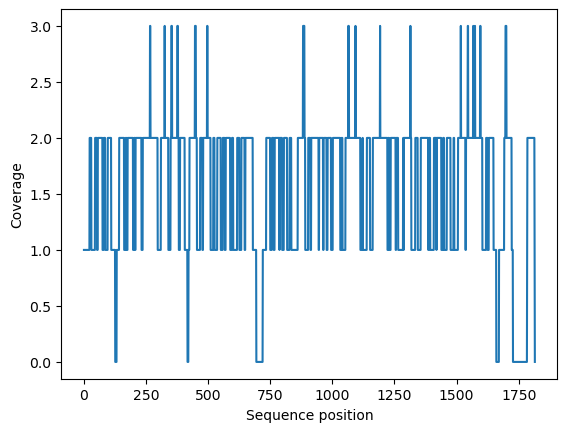

In [47]:
# Let's plot the probe coverage of an example transcript
seq_len = len(transcriptome[transcriptome['transcript_id'] == 'ENSMUST00000051401.4'].iloc[0]['sequence'])
plot.plot_sequence_coverage(probe_dict['Cldn4']['ENSMUST00000051401.4'], seq_len)

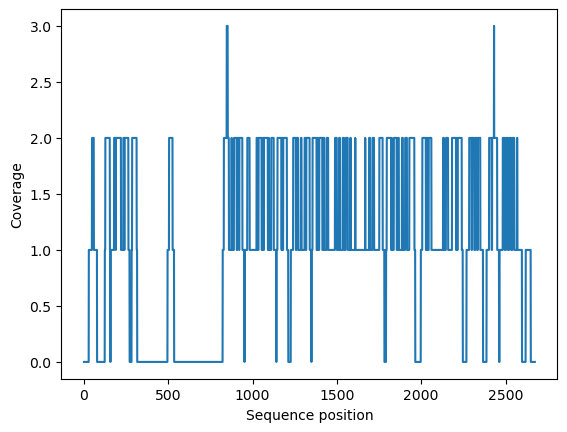

In [48]:
# Let's plot the probe coverage of an example transcript
seq_len = len(transcriptome[transcriptome['transcript_id'] == 'ENSMUST00000031565.15'].iloc[0]['sequence'])
plot.plot_sequence_coverage(probe_dict['Fscn1']['ENSMUST00000031565.15'], seq_len)

Calculate OTs for 0/2 genes.
Calculate OTs for 1/2 genes.


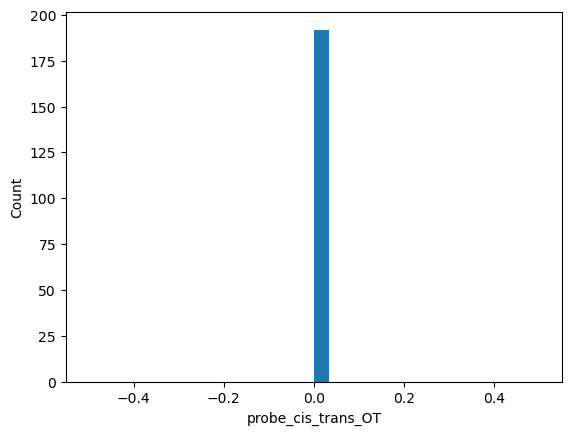

In [49]:
# Iterately remove the probes with high numbers of cis/trans-complementarity
# This filtering strategy is a compromise between speed and the number of probes to keep
while True:
    # Make a OTTable from the reverse-complement sequences of the probes.
    ottable_probes_rc = ot.get_OTTable_for_probe_dictionary(probe_dict, 'target_readout_sequence', 15, rc=True)
    
    # The off-targets in this table indicates cis/trans-complementarity
    ot.calc_OTs(probe_dict, ottable_probes_rc, 'target_readout_sequence', 'probe_cis_trans_OT', 15)
    max_ot = max(plot.get_values_from_probe_dict(probe_dict, 'probe_cis_trans_OT'))
    if max_ot == 0:
        break
    
    # Remove probes that have any cis/trans-complementarity
    filters.filter_probe_dict_by_metric(probe_dict, 'probe_cis_trans_OT', upper_bound=max_ot - 0.5)
    
plot.plot_hist(probe_dict, 'probe_cis_trans_OT')

# Output

## Default csv output

In [50]:
# Get the reverse-complementary sequences of the designed probes
p_d.get_rc_sequences(probe_dict, 'target_readout_primer_sequence', 'target_readout_primer_sequence_rc')

# Get a data frame of all probes
df_all_probes = p_d.probe_dict_to_df(probe_dict)#.sort_values(by=['gene_id','shift'])

# Make a column of probe names
probe_names = np.array(df_all_probes['gene_id']) + '_' + np.array(df_all_probes['transcript_id'])
probe_names = probe_names + '_shift:' + np.array(df_all_probes['shift']).astype(str)
probe_names = probe_names + '_GC:' + np.array(df_all_probes['target_GC']).astype('|S4').astype(str)
probe_names = probe_names + '_Tm:' + np.array(df_all_probes['target_Tm']).astype('|S4').astype(str)
probe_names = probe_names + '_specificity:' + np.array(df_all_probes['target_specificity']).astype('|S1').astype(str)
probe_names = probe_names + '_isospecificity:' + np.array(df_all_probes['target_isospecificity']).astype('|S4').astype(str)
probe_names = probe_names + '_' + np.array(df_all_probes['readout_names'])
df_all_probes['probe_names'] = probe_names

# Write the designed probes
print(probe_output_file)
df_all_probes.to_csv(probe_output_file, index=False)

/lab/solexa_weissman/puzheng/MERFISH_Probes/smFISH/Cldn4_Fscn1/designed_probes.csv


/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/probe_dict.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(probe_dict[gk][tk], ignore_index=True)


In [51]:
df_all_probes

,gene_id,transcript_id,shift,target_sequence,target_GC,target_Tm,target_OT_rtRNA,target_specificity,target_isospecificity,readout_names,probe_barcode,target_readout_sequence,target_readout_primer_sequence,target_readout_primer_sequence_t7_transcribed,probe_cis_trans_OT,target_readout_primer_sequence_rc,probe_names
0,Cldn4,ENSMUST00000051401.4,882,CCTGTGGCCCCTCACATTCTCCAGGACCTG,63.333333,60.698428,0,1.0,0.010000,Stv_6::Stv_4:Stv_3,11010000,GCCACGGTCCCGTTGAACTTaCCTGTGGCCCCTCACATTCTCCAGG...,GGATTGCCGCATGGTTTCCGGCCACGGTCCCGTTGAACTTaCCTGT...,GGGATTGCCGCATGGTTTCCGGCCACGGTCCCGTTGAACTTaCCTG...,0,CCCGCAATGGCTGACAACCGCCCATGATCGTCCGATCTGGtAACGA...,Cldn4_ENSMUST00000051401.4_shift:882_GC:63.3_T...
1,Cldn4,ENSMUST00000051401.4,376,AGTGCAAGATGTACGACTCGATGCTCGCCC,56.666667,56.870008,0,1.0,0.010000,Stv_6::Stv_5:Stv_4,01110000,GCCACGGTCCCGTTGAACTTaAGTGCAAGATGTACGACTCGATGCT...,GGATTGCCGCATGGTTTCCGGCCACGGTCCCGTTGAACTTaAGTGC...,GGGATTGCCGCATGGTTTCCGGCCACGGTCCCGTTGAACTTaAGTG...,0,CCCGCAATGGCTGACAACCGAACGAGACGGTCAATCGCGCtAGTGA...,Cldn4_ENSMUST00000051401.4_shift:376_GC:56.6_T...
2,Cldn4,ENSMUST00000051401.4,757,ACGACAAGCCCTACTCGGCCAAGTACTCCG,60.000000,59.658103,0,1.0,0.010000,Stv_4::Stv_5:Stv_3,11100000,GCGCGATTGACCGTCTCGTTaACGACAAGCCCTACTCGGCCAAGTA...,GGATTGCCGCATGGTTTCCGGCGCGATTGACCGTCTCGTTaACGAC...,GGGATTGCCGCATGGTTTCCGGCGCGATTGACCGTCTCGTTaACGA...,0,CCCGCAATGGCTGACAACCGCCCATGATCGTCCGATCTGGtAGTGA...,Cldn4_ENSMUST00000051401.4_shift:757_GC:60.0_T...
3,Cldn4,ENSMUST00000051401.4,1053,CCAAATTGCTGGTGGATATGGGGCTGAAGG,53.333333,57.178216,0,1.0,0.010000,Stv_3::Stv_5:Stv_6,10110000,CCAGATCGGACGATCATGGGaCCAAATTGCTGGTGGATATGGGGCT...,GGATTGCCGCATGGTTTCCGCCAGATCGGACGATCATGGGaCCAAA...,GGGATTGCCGCATGGTTTCCGCCAGATCGGACGATCATGGGaCCAA...,0,CCCGCAATGGCTGACAACCGAAGTTCAACGGGACCGTGGCtAGTGA...,Cldn4_ENSMUST00000051401.4_shift:1053_GC:53.3_...
4,Cldn4,ENSMUST00000051401.4,1506,TGTCCCCACCCCTTTTCCGCACTGTCTTGC,60.000000,61.053560,0,1.0,0.010000,Stv_4::Stv_5:Stv_6,01110000,GCGCGATTGACCGTCTCGTTaTGTCCCCACCCCTTTTCCGCACTGT...,GGATTGCCGCATGGTTTCCGGCGCGATTGACCGTCTCGTTaTGTCC...,GGGATTGCCGCATGGTTTCCGGCGCGATTGACCGTCTCGTTaTGTC...,0,CCCGCAATGGCTGACAACCGAAGTTCAACGGGACCGTGGCtAGTGA...,Cldn4_ENSMUST00000051401.4_shift:1506_GC:60.0_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,Fscn1,ENSMUST00000031565.15,179,CAGCCGAGGCGTTCGGGTTCAAGGTGAACG,63.333333,60.402934,0,1.0,0.500000,Stv_10::Stv_8:Stv_9,00000111,CGGTCCACCGTTGCGCTTACaCAGCCGAGGCGTTCGGGTTCAAGGT...,GGATTGCCGCATGGTTTCCGCGGTCCACCGTTGCGCTTACaCAGCC...,GGGATTGCCGCATGGTTTCCGCGGTCCACCGTTGCGCTTACaCAGC...,0,CCCGCAATGGCTGACAACCGTTAGTCGTCGCAACGCCAGGtGCAAG...,Fscn1_ENSMUST00000031565.15_shift:179_GC:63.3_...
188,Fscn1,ENSMUST00000031565.15,910,AACGAGAGGAACGTGTCCACGCGCCAGGGA,63.333333,62.094717,0,1.0,0.333333,Stv_8::Stv_9:Stv_7,00001110,CCGTAACGAGCGTCCCTTGCaAACGAGAGGAACGTGTCCACGCGCC...,GGATTGCCGCATGGTTTCCGCCGTAACGAGCGTCCCTTGCaAACGA...,GGGATTGCCGCATGGTTTCCGCCGTAACGAGCGTCCCTTGCaAACG...,0,CCCGCAATGGCTGACAACCGTCTGTTTGACGCGCTGGACGtTTAGT...,Fscn1_ENSMUST00000031565.15_shift:910_GC:63.3_...
189,Fscn1,ENSMUST00000031565.15,1061,CGACCGGAGGTGTGCAATCCACTGCGTCCA,63.333333,61.210707,0,1.0,0.166667,Stv_8::Stv_10:Stv_9,00000111,CCGTAACGAGCGTCCCTTGCaCGACCGGAGGTGTGCAATCCACTGC...,GGATTGCCGCATGGTTTCCGCCGTAACGAGCGTCCCTTGCaCGACC...,GGGATTGCCGCATGGTTTCCGCCGTAACGAGCGTCCCTTGCaCGAC...,0,CCCGCAATGGCTGACAACCGTTAGTCGTCGCAACGCCAGGtGTAAG...,Fscn1_ENSMUST00000031565.15_shift:1061_GC:63.3...
190,Fscn1,ENSMUST00000031565.15,2403,CCCAGCTCTGGCTCTGTGATTGGTGCTCCA,60.000000,59.379229,0,1.0,0.500000,Stv_9::Stv_7:Stv_10,00001011,CCTGGCGTTGCGACGACTAAaCCCAGCTCTGGCTCTGTGATTGGTG...,GGATTGCCGCATGGTTTCCGCCTGGCGTTGCGACGACTAAaCCCAG...,GGGATTGCCGCATGGTTTCCGCCTGGCGTTGCGACGACTAAaCCCA...,0,CCCGCAATGGCTGACAACCGGTAAGCGCAACGGTGGACCGtTCTGT...,Fscn1_ENSMUST00000031565.15_shift:2403_GC:60.0...


In [52]:
from Bio.Seq import reverse_complement
gene_probes = df_all_probes[df_all_probes['gene_id'] == 'Fscn1']
shifts, readout_names = np.array(gene_probes['shift']), np.array(gene_probes['readout_names'])

gene_probe_readouts = []
for _i, _row in gene_probes.iterrows():
    _shift = _row['shift']
    _seq = str(_row['target_readout_primer_sequence_rc'])
    _probe_readouts = []
    
    # check probe seq
    for _j, _readout_row in readout_df.iterrows():
        if _j > 30:
            break
        if reverse_complement(_readout_row['sequence']) in _seq:
            _probe_readouts.append(_readout_row['id'])
    
    gene_probe_readouts.append(np.array(_probe_readouts))
    #print(_shift, _row['readout_names'], _probe_readouts)
# sort 
#readout_names = readout_names[np.argsort(shifts)]
#shifts = shifts[np.argsort(shifts)]
#gene_probe_readouts = np.array(gene_probe_readouts)[np.argsort(shifts)]
for _shift, _readouts, _real_readouts in zip(shifts, readout_names, gene_probe_readouts):
    print(_shift, _readouts, _real_readouts)

190 Stv_9::Stv_8:Stv_10 ['Stv_8' 'Stv_9' 'Stv_10']
48 Stv_8::Stv_7:Stv_10 ['Stv_7' 'Stv_8' 'Stv_10']
2211 Stv_9::Stv_8:Stv_7 ['Stv_7' 'Stv_8' 'Stv_9']
1609 Stv_10::Stv_7:Stv_9 ['Stv_7' 'Stv_9' 'Stv_10']
1668 Stv_7::Stv_8:Stv_10 ['Stv_7' 'Stv_8' 'Stv_10']
1350 Stv_7::Stv_9:Stv_10 ['Stv_7' 'Stv_9' 'Stv_10']
1241 Stv_7::Stv_8:Stv_9 ['Stv_7' 'Stv_8' 'Stv_9']
1142 Stv_10::Stv_8:Stv_9 ['Stv_8' 'Stv_9' 'Stv_10']
1930 Stv_7::Stv_10:Stv_9 ['Stv_7' 'Stv_9' 'Stv_10']
1886 Stv_10::Stv_8:Stv_7 ['Stv_7' 'Stv_8' 'Stv_10']
2321 Stv_8::Stv_9:Stv_10 ['Stv_8' 'Stv_9' 'Stv_10']
234 Stv_9::Stv_7:Stv_8 ['Stv_7' 'Stv_8' 'Stv_9']
2130 Stv_9::Stv_8:Stv_10 ['Stv_8' 'Stv_9' 'Stv_10']
2503 Stv_7::Stv_8:Stv_9 ['Stv_7' 'Stv_8' 'Stv_9']
830 Stv_10::Stv_7:Stv_9 ['Stv_7' 'Stv_9' 'Stv_10']
2075 Stv_7::Stv_10:Stv_8 ['Stv_7' 'Stv_8' 'Stv_10']
2285 Stv_8::Stv_10:Stv_9 ['Stv_8' 'Stv_9' 'Stv_10']
2541 Stv_8::Stv_9:Stv_7 ['Stv_7' 'Stv_8' 'Stv_9']
1742 Stv_10::Stv_8:Stv_7 ['Stv_7' 'Stv_8' 'Stv_10']
999 Stv_9::Stv_7:Stv_10 ['S

## IDT oPool version output

In [53]:
# calculate gene_2_bits
gene_2_bits = {}
for _gene in np.unique(df_all_probes['gene_id']):
    _readouts = np.unique([_n.split(':')
                           for _n in np.unique(df_all_probes.loc[df_all_probes['gene_id']==_gene, 'readout_names'])])
    _readouts = [_r for _r in _readouts if len(_r)]
    print(_gene, _readouts)
    gene_2_bits[_gene] = _readouts

Cldn4 ['Stv_3', 'Stv_4', 'Stv_5', 'Stv_6']
Fscn1 ['Stv_10', 'Stv_7', 'Stv_8', 'Stv_9']


In [54]:
len(df_all_probes['target_readout_primer_sequence_rc'][6])

133

In [55]:
df_idt_probes = {'Pool name':[], 'Sequence':[]}
for _gene, _seq in zip(df_all_probes['gene_id'], df_all_probes['target_readout_primer_sequence_rc']):
    df_idt_probes['Pool name'].append(f"smFISH_{_gene}_"+str(gene_2_bits[_gene]).replace('\'','').replace(' ','').replace('Bit-','b'))
    #df_idt_probes['Pool name'].append('smFISH_LungCancerTest1')
    df_idt_probes['Sequence'].append(_seq)
df_idt_probes = pd.DataFrame(df_idt_probes)
df_idt_probes

,Pool name,Sequence
0,"smFISH_Cldn4_[Stv_3,Stv_4,Stv_5,Stv_6]",CCCGCAATGGCTGACAACCGCCCATGATCGTCCGATCTGGtAACGA...
1,"smFISH_Cldn4_[Stv_3,Stv_4,Stv_5,Stv_6]",CCCGCAATGGCTGACAACCGAACGAGACGGTCAATCGCGCtAGTGA...
2,"smFISH_Cldn4_[Stv_3,Stv_4,Stv_5,Stv_6]",CCCGCAATGGCTGACAACCGCCCATGATCGTCCGATCTGGtAGTGA...
3,"smFISH_Cldn4_[Stv_3,Stv_4,Stv_5,Stv_6]",CCCGCAATGGCTGACAACCGAAGTTCAACGGGACCGTGGCtAGTGA...
4,"smFISH_Cldn4_[Stv_3,Stv_4,Stv_5,Stv_6]",CCCGCAATGGCTGACAACCGAAGTTCAACGGGACCGTGGCtAGTGA...
...,...,...
187,"smFISH_Fscn1_[Stv_10,Stv_7,Stv_8,Stv_9]",CCCGCAATGGCTGACAACCGTTAGTCGTCGCAACGCCAGGtGCAAG...
188,"smFISH_Fscn1_[Stv_10,Stv_7,Stv_8,Stv_9]",CCCGCAATGGCTGACAACCGTCTGTTTGACGCGCTGGACGtTTAGT...
189,"smFISH_Fscn1_[Stv_10,Stv_7,Stv_8,Stv_9]",CCCGCAATGGCTGACAACCGTTAGTCGTCGCAACGCCAGGtGTAAG...
190,"smFISH_Fscn1_[Stv_10,Stv_7,Stv_8,Stv_9]",CCCGCAATGGCTGACAACCGGTAAGCGCAACGGTGGACCGtTCTGT...


In [56]:
# Write the designed probes
print(probe_output_idt_file)
df_idt_probes.to_excel(probe_output_idt_file, index=False)

/lab/solexa_weissman/puzheng/MERFISH_Probes/smFISH/Cldn4_Fscn1/designed_probes_idt_oPool.xlsx


## Test the sequence direction

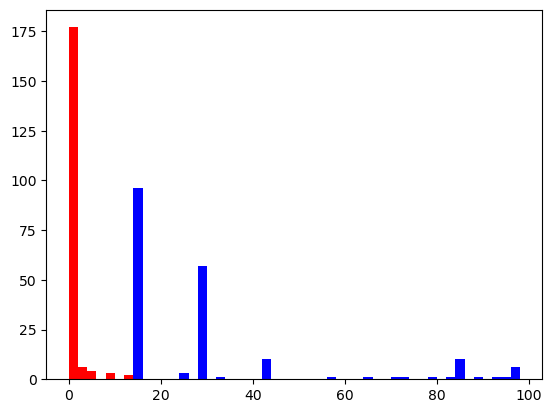

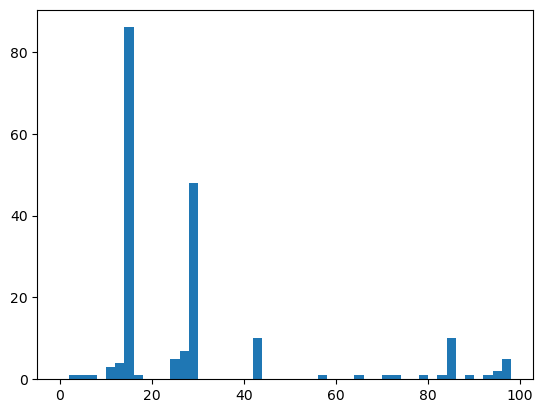

In [57]:
from Bio.Seq import reverse_complement
import matplotlib.pyplot as plt

ct_list, rc_ct_list = [], []

for _probe_seq in df_idt_probes['Sequence']:
    _target_seq = _probe_seq[62:92]
    _target_rc_seq = reverse_complement(_target_seq)
    _ct, _rc_ct = 0, 0
    for _i in range(0,30-17+1):
        _ct += ottable_transcriptome[_target_seq[_i:_i+17]]
        _rc_ct += ottable_transcriptome[_target_rc_seq[_i:_i+17]]
    #print(_ct, _rc_ct)
    ct_list.append(_ct)
    rc_ct_list.append(_rc_ct)
    
plt.figure()
plt.hist(ct_list, bins=np.arange(0,100,2), color='red')
plt.hist(rc_ct_list, bins=np.arange(0,100,2), color='blue')
plt.show()
plt.figure()
plt.hist(np.array(rc_ct_list) - np.array(ct_list), bins=np.arange(0,100,2))
plt.show()

# IDT plate without primers

In [58]:
all_well_positions = []
for _row in list('ABCDEFGH'):
    for _col in range(1,13,1):
        all_well_positions.append(f"{_row}{_col}")

In [59]:
probe_plate_df = {
    'Well Position':[], 
    'Name':[], 
    'Sequence':[],
}

for _i, (_name, _seq) in df_all_probes[['probe_names','target_readout_primer_sequence_rc']].iterrows():
    if 'mCherry' in _name:
        probe_plate_df['Name'].append(_name)
        probe_plate_df['Sequence'].append('/5Acryd/' + _seq[40:90])
# add well position
probe_plate_df['Well Position'] = all_well_positions[:len(probe_plate_df['Name'])]
probe_plate_df = pd.DataFrame(probe_plate_df)

In [60]:
probe_plate_df

,Well Position,Name,Sequence


In [61]:
# save
import time
overwrite = True
save_common_probe_plate_filename = os.path.join(library_folder,
                             f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_smFISH_mCherry_IDTplate.xlsx")

if not os.path.exists(save_common_probe_plate_filename) or overwrite:
    print(f"saving probes to file: {save_common_probe_plate_filename}")
    probe_plate_df.to_excel(save_common_probe_plate_filename, index=None)

saving probes to file: /lab/solexa_weissman/puzheng/MERFISH_Probes/smFISH/Cldn4_Fscn1/2024_3_20_smFISH_mCherry_IDTplate.xlsx
